## Load the data

In [22]:
import os
import glob
import SimpleITK as sitk
import numpy as np
import pydicom
import matplotlib.pyplot as plt
%matplotlib widget
import nibabel as nib
import torch
from skimage import exposure
import seaborn as sns
from sewar.full_ref import mse
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm   # nopep8

from scripts.torch.utils import *
from scipy import ndimage
from skimage.morphology import area_closing, binary_dilation
from skimage.exposure import match_histograms
import cv2


In [23]:
def minmax(img):
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

def preprocess(array, new_shape, range=10):
    temp = resize_img(sitk.GetImageFromArray(array), new_shape, sitk.sitkLinear)
    min, max = float(sitk.GetArrayFromImage(temp).min()), float(sitk.GetArrayFromImage(temp).max())
    # print(f"Pixel range {min, max}")
    temp = sitk.Threshold(temp, lower=min+range, upper=max, outsideValue=0)
    return minmax(sitk.GetArrayFromImage(temp)) 
    # return sitk.GetArrayFromImage(temp)

def seg(img, new_shape):
    img = (img*255).astype(np.uint8)
    cnt = sorted(cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
    mask = np.zeros(new_shape, np.uint8)
    masked = cv2.drawContours(mask, [cnt],-1, 255, -1)
    return masked

In [24]:
from sklearn.preprocessing import normalize

(192, 164) [1.4583333730698, 1.4583333730698]
(192, 164) [1.4583333730698, 1.4583333730698]


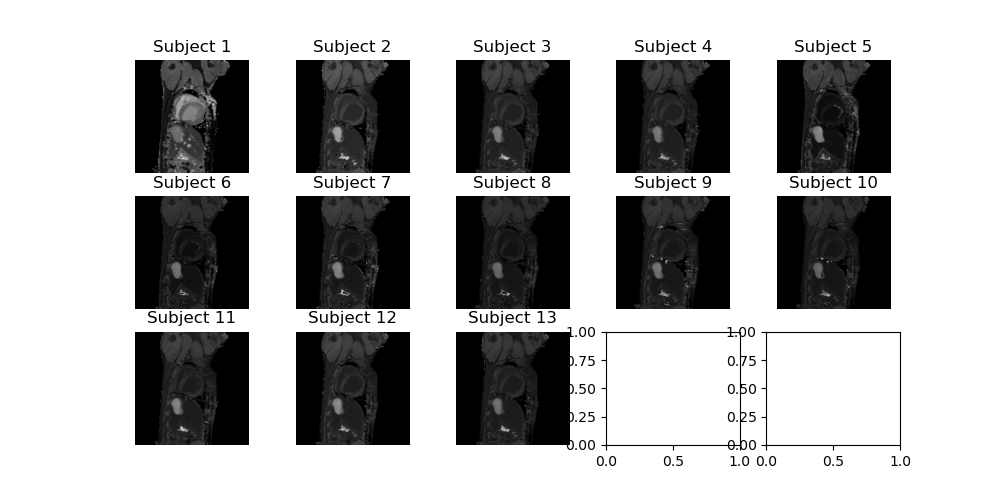

In [25]:
fixed_file = '/Users/mona/Documents/data/registration/Lisbon/Lisbon_D8/PreconT1/T1MAP_SAX5_MOCO_T1_0058/LISBON_DAY8.MR.HEART_CEDARS.0058.0001.2021.11.17.14.45.46.506126.16832097.IMA'
moco_file = '/Users/mona/Library/CloudStorage/Box-Box/Animals/Lisbon/Lisbon_D8/PreT1w_moco/T1MAP_SAX5_MOCO_0057/LISBON_DAY8.MR.HEART_CEDARS.0057.0001.2021.11.17.14.45.46.506126.16831936.IMA'

fixed_img = pydicom.read_file(fixed_file)
moco_img = pydicom.read_file(moco_file)
print(fixed_img.pixel_array.shape, fixed_img.PixelSpacing)
print(moco_img.pixel_array.shape, moco_img.PixelSpacing)

new_shape = (192, 192)
fixed_array = preprocess(fixed_img.pixel_array, new_shape, 50)
moco_array = preprocess(moco_img.pixel_array, new_shape, 20)
original = moco_array
mask = moco_array > 0
# fixed_array = normalize(fixed_array)
# fixed_array = match_histograms(fixed_array, moco_array)
fixed_array = fixed_array * mask


moved_folder = '/Users/mona/Documents/data/registration/Lisbon/Lisbon_D8/PostconT1'
moco_root = '/Users/mona/Library/CloudStorage/Box-Box/Animals/Lisbon/Lisbon_D8/PostT1w_moco'
moco_folder = sorted(os.listdir(moco_root))
subjects = sorted(os.listdir(moved_folder))
moved_vol = [fixed_array]
mask_vol = [mask]
for idx, subject in enumerate(subjects):
    if os.path.isdir(os.path.join(moved_folder, subject)):
        scans = glob.glob(os.path.join(moved_folder, subject, "*.IMA"))
        moco_scans = glob.glob(os.path.join(moco_root, moco_folder[idx], "*.IMA"))
        for file in scans:
            moved_img = pydicom.read_file(file)
            moco_img = pydicom.read_file(moco_scans[0])
            moved_array = preprocess(moved_img.pixel_array, new_shape, 50)
            moco_array = preprocess(moco_img.pixel_array, new_shape, 20)
            mask = moco_array > 0
            # moved_array = match_histograms(moved_array, fixed_array)
            # moved_array = normalize(moved_array)
            moved_array = moved_array * mask
            
            
            moved_vol.append(moved_array)
            mask_vol.append(mask)
# plt.imshow(moco_array, cmap='gray')
figure, axes = plt.subplots(3, 5, figsize=(10, 5))
for i in range(len(moved_vol)):
    axes[i//5, i%5].imshow(moved_vol[i], cmap='gray')
    axes[i//5, i%5].axis('off')
    axes[i//5, i%5].set_title(f"Subject {i+1}")
# for i in range(len(mask_vol)):
#     axes[i//5, i%5].imshow(mask_vol[i], cmap='gray')
#     axes[i//5, i%5].axis('off')
#     axes[i//5, i%5].set_title(f"Subject {i+1}")

## Load the registration model

In [26]:
device = 'cpu'
model_path = 'model/Lisbon_ncc_0.01/1000.pt'
# load and set up model
model = vxm.networks.VxmDense.load(model_path, device)
model.to(device)
model.eval()

VxmDense(
  (unet_model): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3

In [27]:
# fixed_array = match_histograms(fixed_array, reference, channel_axis=-1)
# fixed_array = preprocess(fixed_array, new_shape, 0)
fixed_array = moved_vol[0]
input_fixed = torch.from_numpy(fixed_array[None, None, ...].astype(np.float32))

# print(f"Mona: vols shape {vols.shape} and input fixed {input_fixed.shape}")

output_moved = [input_fixed.squeeze()]
output_warp = []
output_orig = [input_fixed.squeeze()]

input_fixed = input_fixed.to(device)
for slice in range(1, len(moved_vol)):
    input_moving = torch.from_numpy(moved_vol[slice][None, None, ...].astype(np.float32))
    # print(f"The shape of moving is {input_moving.shape} and shape of fixed {input_fixed.shape}")
    moved, warp = model(input_moving, input_fixed, registration=True) # register all sequence to the first sequence

    output_moved.append(moved.detach().cpu().numpy().squeeze())
    output_warp.append(warp.detach().cpu().numpy().squeeze())
    output_orig.append(input_moving.detach().cpu().numpy().squeeze())


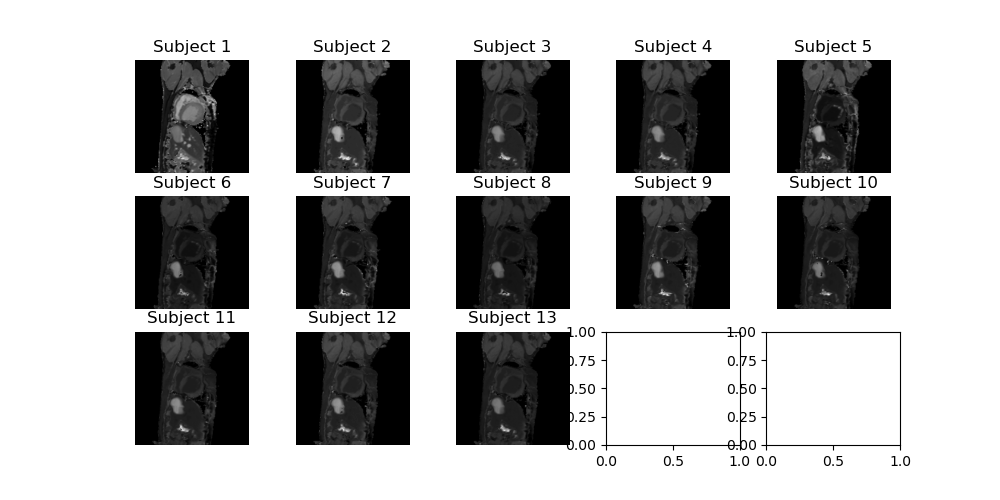

In [28]:
figure, axes = plt.subplots(3, 5, figsize=(10, 5))
for i in range(len(output_moved)):
    axes[i//5, i%5].imshow(output_moved[i], cmap='gray')
    axes[i//5, i%5].axis('off')
    axes[i//5, i%5].set_title(f"Subject {i+1}")

In [29]:
moved = np.stack(output_moved)
warp = np.stack(output_warp)
orig = np.stack(output_orig)

moved = exposure.equalize_hist(moved)
warp = exposure.equalize_hist(warp)
orig = exposure.equalize_hist(orig)

moved_path = 'results/Lisbon_ncc_0.01/moved'
warp_path = 'results/Lisbon_ncc_0.01/warp'
os.makedirs(moved_path, exist_ok=True)
os.makedirs(warp_path, exist_ok=True)
fixed_affine = None

vxm.py.utils.save_volfile(moved, os.path.join(moved_path, "test.nii"), fixed_affine)

warp = warp.transpose(2, 3, 0, 1)
vxm.py.utils.save_volfile(warp, os.path.join(warp_path, "test.nii"), fixed_affine)

orig = orig.transpose(1, 2, 0)
moved = moved.transpose(1, 2, 0)
warp = warp.transpose(3, 2, 1, 0)
warp = np.flip(warp, axis=2)
# print(f"Shape of orig {orig.shape} and moved {moved.shape} and warp {warp.shape}")
moved_gif_path = save_gif(moved, "test", moved_path, "registered")
orig_gif_path = save_gif(orig, "test", moved_path, "original")
# quiver_path = save_quiver(warp, 'test', warp_path)